In [6]:
import gymnasium as gym
from collections import namedtuple
import itertools
from itertools import count
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import numpy as np
import collections
import random
import matplotlib.pyplot as plt
import imageio

In [7]:
##  构造策略网络的
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))  ## 激活函数的，>0，和relu类似
        dist = Normal(mu, std)
        normal_sample = dist.rsample()  # rsample()是重参数化采样，单独的高斯分布采样不可导，重参数化可导的
        log_prob = dist.log_prob(normal_sample) ##  从分布内采样概率，并算出概率的log值
        action = torch.tanh(normal_sample)    ## 确定性策略输出的动作值，不是概率的，分布在 -1到1 之间
        # 计算tanh_normal分布的对数概率密度
        ## 熵的相反数
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        action = action * self.action_bound   ## 输出动作的，缩放到区间内
        return action, log_prob

## 状态动作价值网络，输出状态动作对 (状态，动作) 的价值
## 也就是动作价值网络
class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)  # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        return self.fc2(x)


device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")


class SAC:
    ''' 处理连续动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim,
                               action_bound).to(device)  # 策略网络
        # 第一个Q网络
        self.critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 第二个Q网络
        self.critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_1 = QValueNet(state_dim, hidden_dim,
                                         action_dim).to(device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNet(state_dim, hidden_dim,
                                         action_dim).to(device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        ## update 熵系数
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(device)
        action = self.actor(state)[0]   ## 拿到确定性策略 网络的输出，也就是确定的动作
        return [action.item()]

    def calc_target(self, rewards, next_states, dones):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob   ## 熵
        q1_value = self.target_critic_1(next_states, next_actions)   ## 目标价值网络的下个状态的价值输出
        q2_value = self.target_critic_2(next_states, next_actions)
        ## 拿到最小的价值输出，然后加上熵，就是目标的下个状态的价值
        next_value = torch.min(q1_value,
                               q2_value) + self.log_alpha.exp() * entropy
        ## 目标当前状态的价值，时序差分的公式
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        ## 延迟update，EMA update，每次 update 很少的部分的
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        ## 拿到这条序列内的 状态、动作和奖励，下一个状态、是否完成的
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(device)
        rewards = (rewards + 8.0) / 8.0  # 对倒立摆环境的奖励进行重塑

        # 更新两个Q网络
        ## 用下一个（状态、动作）对的动作价值 Q，然后间接求出当前的（状态、动作）对的动作价值
        td_target = self.calc_target(rewards, next_states, dones)
        ## 直接求出当前（状态、动作）的动作价值，和 间接求出的动作价值，使用 MSE 来算损失函数的，q_targets不反向传播求梯度
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad() ## 价值网络的参数梯度置零的
        critic_1_loss.backward() ## 价值网络的损失loss反向传播梯度
        self.critic_1_optimizer.step() ## update 网络
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        ## self.actor(states) 是输出当前状态的动作，以及熵的相反数
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob  ## 熵
        ## 此时的动作价值网络已经 update 了的
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        ## update以后的动作价值网络，使用当前的（状态、动作）的动作价值，加了负号的，也就是最大化动作价值的
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
            (entropy - target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

In [8]:
class Swish(nn.Module):
    ''' Swish激活函数 '''
    def __init__(self):
        super(Swish, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

def init_weights(m):
    ''' 初始化模型权重 '''
    ##  就是截断正态分布的
    def truncated_normal_init(t, mean=0.0, std=0.01):
        torch.nn.init.normal_(t, mean=mean, std=std)     ## 用均值=0，标准差是std的正态分布，来初始化模型的权重
        while True:   ## 做截断
            ##  截断区间是 [mean - 2 * std, mean + 2 * std]，也就是拿到不满足条件的布尔值
            cond = (t < mean - 2 * std) | (t > mean + 2 * std)   ## 截断的条件是 标准差的 -2倍到2倍
            if not torch.sum(cond): ## 权重的所有值是否 都被 截断到 区间内
                break  ## 都被截断到区间内，退出循环返回的
            ##  不满足截断条件的地方，再次初始化
            t = torch.where(cond, torch.nn.init.normal_(torch.ones(t.shape, device=device), mean=mean, std=std), t)
        return t
    ## 只有 full connect layer层才有权重需要被初始化
    if type(m) == nn.Linear or isinstance(m, FCLayer):
        truncated_normal_init(m.weight, std=1 / (2 * np.sqrt(m._input_dim)))
        m.bias.data.fill_(0.0)

class FCLayer(nn.Module):
    ''' 集成之后的全连接层 '''
    def __init__(self, input_dim, output_dim, ensemble_size, activation):
        super(FCLayer, self).__init__()
        self._input_dim, self._output_dim = input_dim, output_dim     ## 输入和输出的 dim
        self.weight = nn.Parameter( 
            torch.Tensor(ensemble_size, input_dim, output_dim).to(device))      ## 配置参数的dim
        self._activation = activation
        self.bias = nn.Parameter(
            torch.Tensor(ensemble_size, output_dim).to(device))       ## 配置参数的dim

    def forward(self, x):
        '''
        torch.bmm：批量的矩阵乘运算
        若输入是(b×n×m)向量, mat2是(b×m×p)向量, 输出是(b×n×p)向量，第一个dim是batch批量
        >>> input = torch.randn(10, 3, 6)
        >>> mat2 = torch.randn(10, 6, 60)
        >>> res = torch.bmm(input, mat2)
        >>> res.size()
        torch.Size([10, 3, 60])
        '''
        return self._activation(
            torch.add(torch.bmm(x, self.weight), self.bias[:, None, :]))  ## 构造环境模型的 full connect 层

In [1]:
class EnsembleModel(nn.Module):
    ''' 环境模型集成 '''
    def __init__(self,
                 state_dim,
                 action_dim,
                 model_alpha,
                 ensemble_size=5,
                 learning_rate=1e-3):
        super(EnsembleModel, self).__init__()
        # 输出包括均值和方差,因此是状态与奖励维度之和的两倍
        ## 每个状态都服从高斯分布，然后奖励也是服从高斯分布，用来捕捉 偶然不确定性
        self._output_dim = (state_dim + 1) * 2
        self._model_alpha = model_alpha  # 模型损失函数中加权时的权重
        self._max_logvar = nn.Parameter((torch.ones(
            (1, self._output_dim // 2)).float() / 2).to(device),
                                        requires_grad=False)         ## 初始化方差的最大值是 1/2
        self._min_logvar = nn.Parameter((-torch.ones(
            (1, self._output_dim // 2)).float() * 10).to(device),
                                        requires_grad=False)         ## 初始化方差的最小值是 -10
        ## 集成的full connect layer
        self.layer1 = FCLayer(state_dim + action_dim, 200, ensemble_size,
                              Swish())
        self.layer2 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer3 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer4 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer5 = FCLayer(200, self._output_dim, ensemble_size,
                              nn.Identity()) ## 最后一层没有激活函数
        self.apply(init_weights)  # 初始化环境模型中的参数
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate) ## 优化器

    ## return_log_var，var是方差，Log_var是方差的log值
    def forward(self, x, return_log_var=False):
        ret = self.layer5(self.layer4(self.layer3(self.layer2(
            self.layer1(x)))))    ##  Sequential顺序执行的模型
        ## 【:self._output_dim // 2】  后半部分是均值的
        mean = ret[:, :, :self._output_dim // 2]
        # 在PETS算法中,将方差控制在最小值和最大值之间
        '''
        可导的上截断操作
        F.softplus和relu类似，返回值都是大于0的，【self._output_dim // 2:】前半部分是log方差的
        self._max_logvar - ret[:, :, self._output_dim // 2:]，比_max_logvar大的数值会小于0
        F.softplus(self._max_logvar - ret[:, :, self._output_dim // 2:])会将小于0的值置0
        self._max_logvar - F.softplus(self._max_logvar - ret[:, :, self._output_dim // 2:]) 恢复开始的值，但是比_max_logvar大的数值都被截断到_max_logvar
        不同于直接截断操作，这里的 F.softplus 是可导的梯度可以传播
        '''
        logvar = self._max_logvar - F.softplus(
            self._max_logvar - ret[:, :, self._output_dim // 2:])
        '''
        可导的下截断操作
        logvar - self._min_logvar，比_min_logvar小的数值会小于0
        F.softplus(logvar - self._min_logvar) 会将小于0的值置0
        self._min_logvar + F.softplus(logvar - self._min_logvar) 恢复开始的值，但是比_min_logvar小的数值都被截断到_min_logvar
        不同于直接截断操作，这里的 F.softplus 是可导的梯度可以传播
        '''
        logvar = self._min_logvar + F.softplus(logvar - self._min_logvar)
        ## 返回环境下一步状态和奖励的高斯分布的均值和log方差，拟合偶然不确定性
        ## 也就是下一步状态 用高斯分布采样，奖励 也用高斯分布采样的
        return mean, logvar if return_log_var else torch.exp(logvar)

    def loss(self, mean, logvar, labels, use_var_loss=True):  ## 损失函数的呢
        inverse_var = torch.exp(-logvar)  ## 方差的
        if use_var_loss:
            ## 求均值 和 label的loss，MSE，两者距离越小越好，然后还乘上了方差的逆
            mse_loss = torch.mean(torch.mean(torch.pow(mean - labels, 2) *   ##(6-1, bs, 2*2)---(6-1)
                                             inverse_var,
                                             dim=-1),
                                  dim=-1)
            ## 方差的 Log 值越小越好，所以可以做损失函数
            var_loss = torch.mean(torch.mean(logvar, dim=-1), dim=-1)
            total_loss = torch.sum(mse_loss) + torch.sum(var_loss)
        else:
            ## 求均值 和 label的loss，MSE，两者距离越小越好
            mse_loss = torch.mean(torch.pow(mean - labels, 2), dim=(1, 2))
            total_loss = torch.sum(mse_loss)
        return total_loss, mse_loss

    def train(self, loss):
        self.optimizer.zero_grad()  ## 参数的梯度置 0 
         ##  _max_logvar 和 _min_logvar 都是不反向传播梯度的，requires_grad=False
        loss += self._model_alpha * torch.sum(
            self._max_logvar) - self._model_alpha * torch.sum(self._min_logvar)
        loss.backward()         ## 反向传播求出梯度
        self.optimizer.step()   ## update求出梯度的


class EnsembleDynamicsModel:
    ''' 环境模型集成,加入精细化的训练 '''
    def __init__(self, state_dim, action_dim, model_alpha=0.01, num_network=5):
        self._num_network = num_network  ## 集成环境模型的个数
        self._state_dim, self._action_dim = state_dim, action_dim   ## 状态的dim，动作的dim
        ## 实例化集成的环境模型
        self.model = EnsembleModel(state_dim,
                                   action_dim,
                                   model_alpha,
                                   ensemble_size=num_network)
        self._epoch_since_last_update = 0

    def train(self,
              inputs,
              labels,
              batch_size=64,
              holdout_ratio=0.1,
              max_iter=20):
        # 设置训练集与验证集
        '''
        np.random.permutation(10)
        array([1, 7, 4, 3, 0, 9, 2, 5, 8, 6]) # random
        np.random.permutation([1, 4, 9, 12, 15])
        array([15,  1,  9,  4, 12]) # random
        '''
        permutation = np.random.permutation(inputs.shape[0])    ## shuffle 输入
        inputs, labels = inputs[permutation], labels[permutation]    ## shuffle 输入
        num_holdout = int(inputs.shape[0] * holdout_ratio) ## 用来验证的比例，20
        ## (200*(1-0.2), 2*2)
        train_inputs, train_labels = inputs[num_holdout:], labels[num_holdout:]   ## 拿到用来训练的输入和label
        ## (20, 2*2)
        holdout_inputs, holdout_labels = inputs[:num_holdout], labels[:num_holdout]  ## 用来验证网络是否收敛
        holdout_inputs = torch.from_numpy(holdout_inputs).float().to(device)  ##  转torch的tensor
        holdout_labels = torch.from_numpy(holdout_labels).float().to(device)
        ## (6-1, 20, 2*2)
        holdout_inputs = holdout_inputs[None, :, :].repeat([self._num_network, 1, 1])              ## 重复很多次，每个环境网络拿到一份输入的拷贝
        holdout_labels = holdout_labels[None, :, :].repeat([self._num_network, 1, 1])              ## 重复很多次，每个环境网络拿到一份label的拷贝

        # 保留最好的结果
        self._snapshots = {i: (None, 1e10) for i in range(self._num_network)} ## 每个环境网络的结果

        ## 训练的epoch计数，不会自动停止，需要 break 才可以
        for epoch in itertools.count():
            # 定义每一个网络的训练数据
            '''
            np.random.permutation(train_inputs.shape[0])  : shuffle 输入数据的 index
            for _ in range(self._num_network)   : 多少个环境网络，就重复多少次的
            因每个网络都做了一次permutation shuffle，所以每个网络的输入数据的sequence都是不相同的，
            虽然总体的训练数据相同，但是因sequence不同导致了每个batch的输入都不相同。
            np.vstack：最后 vstack起来的，也就是最后的输入 index
            下面的输出train_index的dim是：(20, 6)
            train_index = np.vstack([
                            np.random.permutation(6)
                            for _ in range(20)
                        ])
            train_index 的 dim 是（ _num_network，train_inputs.shape[0]）
            '''
            ## (6-1, 200-20)
            train_index = np.vstack([
                np.random.permutation(train_inputs.shape[0])
                for _ in range(self._num_network)
            ])
            # 所有真实数据都用来训练
            for batch_start_pos in range(0, train_inputs.shape[0], batch_size):    ## 每次输入的数量是 batch_size 个
                ## train_index的第一个dim是 环境网络的个数，第二个dim才是 数据的个数 （6-1，bs）
                batch_index = train_index[:, batch_start_pos:batch_start_pos +
                                          batch_size]   ## (num_network, train_input.shape[0])
                train_input = torch.from_numpy(
                    train_inputs[batch_index]).float().to(device)    ## 拿到输入的数据，（6-1，bs, 2*2）
                train_label = torch.from_numpy(
                    train_labels[batch_index]).float().to(device)    ## 输入的label，（6-1，bs, 2*2）
                ## train 集成起来的多个环境模型 （6-1，bs, 2*2） （6-1，bs, 2*2）
                mean, logvar = self.model(train_input, return_log_var=True)
                loss, _ = self.model.loss(mean, logvar, train_label)  ## 算 loss
                self.model.train(loss)    ## train

            with torch.no_grad():  ## 不算梯度的
                mean, logvar = self.model(holdout_inputs, return_log_var=True)   ## 其他的数据前向传播 （6-1，20, 2*2）（6-1，20, 2*2）
                _, holdout_losses = self.model.loss(mean,
                                                    logvar,
                                                    holdout_labels,
                                                    use_var_loss=False)   ## 算出loss的，只算均值损失，不算方差的损失
                holdout_losses = holdout_losses.cpu()
                break_condition = self._save_best(epoch, holdout_losses)  ## 根据损失的下降程度，决定是否保存模型
                if break_condition or epoch > max_iter:  # 结束训练
                    break

    def _save_best(self, epoch, losses, threshold=0.1):
        updated = False     ## 是否 update 模型的
        for i in range(len(losses)):
            current = losses[i]            ## 当前的损失
            _, best = self._snapshots[i]   ## 保存的损失
            improvement = (best - current) / best    ## 损失下降的比例
            if improvement > threshold:    ## 下降的比例大于 threshold
                self._snapshots[i] = (epoch, current)  ## 保存当前的epoch和损失
                updated = True    ## 损失update过了的
        ## 用来做train的终止条件的，若是距离上次 update 已经过去了6个epoch，那么就可以终止train
        self._epoch_since_last_update = 0 if updated else self._epoch_since_last_update + 1
        return self._epoch_since_last_update > 5

    def predict(self, inputs, batch_size=64):
        ## 使用多个环境模型来 predict 下个状态和奖励分布的 均值和方差
        inputs = np.tile(inputs, (self._num_network, 1, 1)) ## (6-1, 1, 2*2)
        inputs = torch.tensor(inputs, dtype=torch.float).to(device)
        mean, var = self.model(inputs, return_log_var=False) ## (6-1, 1, 2*2)
        return mean.detach().cpu().numpy(), var.detach().cpu().numpy()

## 构造的虚拟环境，不是真实环境的，虚拟环境只在CEM交叉熵方式选取动作时需要用到，其他地方用不到
class FakeEnv:
    def __init__(self, model):
        ## 集成环境模型
        self.model = model

    def step(self, obs, act):
        inputs = np.concatenate((obs, act), axis=-1)    ## 拼接状态和动作 （n_sequence, 2*2）
        ## 虚拟环境来predict 下个状态和奖励的 均值和方差
        ensemble_model_means, ensemble_model_vars = self.model.predict(inputs)  ##  （6-1, n_sequence, 2*2）（6-1, n_sequence, 2*2）
        '''
        下个状态的均值 加上 当前的状态，所以集成环境模型，返回的均值其实是当前状态的残差
        需要加上当前状态，才是真正的下一个状态的均值
        '''
        ensemble_model_means[:, :, 1:] += obs
        ensemble_model_stds = np.sqrt(ensemble_model_vars)
        ## 标准正态分布采样，然后乘标准差加均值，变到常规正态分布 (ensemble_model_means, ensemble_model_stds**2) 采样
        ensemble_samples = ensemble_model_means + np.random.normal(
            size=ensemble_model_means.shape) * ensemble_model_stds    ## （6-1, n_sequence, 2*2）

        num_models, batch_size, _ = ensemble_model_means.shape ## 均值的shape  （6-1, n_sequence, 2*2）
        models_to_use = np.random.choice(
            [i for i in range(self.model._num_network)], size=batch_size)  ## 随机选择环境模型 ##(batch_size,)
        batch_inds = np.arange(0, batch_size)
        samples = ensemble_samples[models_to_use, batch_inds]   ## 拿到实际的采样值  ##(batch_size,2*2)
        rewards, next_obs = samples[:, :1][0][0], samples[:, 1:][0]        ## 拿出 奖励值，以及 下一个状态  (batch_size, 1)  (batch_size, 2*2-1)
        return rewards, next_obs

NameError: name 'nn' is not defined

In [1]:
class MBPO:
    def __init__(self, env, agent, fake_env, env_pool, model_pool,
                 rollout_length, rollout_batch_size, real_ratio, num_episode):

        self.env = env   ## 真实环境的
        self.agent = agent ## 智能体 SAC algorithm
        self.fake_env = fake_env ## 虚拟环境的
        self.env_pool = env_pool  ## 智能体和真实环境交互得到的历史数据缓冲池
        self.model_pool = model_pool  ## 智能体和虚拟环境交互得到的历史数据缓冲池，智能体和虚拟环境交互，也就是mbpo的分支
        self.rollout_length = rollout_length  ## mbpo分支向前看的步长
        self.rollout_batch_size = rollout_batch_size  ## mbpo采样的状态个数，也就是分支的起点的个数
        self.real_ratio = real_ratio ## 和真实环境交互的历史数据 的比例
        self.num_episode = num_episode ## episodes的数量

    ## mbpo真实状态分支采样，步长是self.rollout_length
    def rollout_model(self):
        observations, _, _, _, _ = self.env_pool.sample(   ## 从历史数据缓冲池，随机采样些状态
            self.rollout_batch_size)
        for obs in observations:
            for i in range(self.rollout_length):  ## MBPO分支向前看的步长
                action = self.agent.take_action(obs)                         ## 智能体根据状态执行动作
                reward, next_obs = self.fake_env.step(obs, action)           ## 虚拟环境下一步，返回奖励和状态
                self.model_pool.add(obs, action, reward, next_obs, False)    ## 加入到 和虚拟环境交互得到的历史数据缓冲池
                obs = next_obs

    def update_agent(self, policy_train_batch_size=64):
        env_batch_size = int(policy_train_batch_size * self.real_ratio)  ##  智能体和真实环境交互的历史数据的数量
        model_batch_size = policy_train_batch_size - env_batch_size      ##  智能体和虚拟环境交互得到的历史数据的数量
        for epoch in range(10):
            env_obs, env_action, env_reward, env_next_obs, env_done = self.env_pool.sample(
                env_batch_size)  ## 从 智能体和真实环境交互得到的历史数据缓冲池，采样
            if self.model_pool.size() > 0:
                model_obs, model_action, model_reward, model_next_obs, model_done = self.model_pool.sample(
                    model_batch_size) ## 从 智能体和虚拟环境交互得到的历史数据缓冲池，采样
                obs = np.concatenate((env_obs, model_obs), axis=0)
                action = np.concatenate((env_action, model_action), axis=0)
                next_obs = np.concatenate((env_next_obs, model_next_obs),
                                          axis=0)
                reward = np.concatenate((env_reward, model_reward), axis=0)
                done = np.concatenate((env_done, model_done), axis=0)
            else:
                obs, action, next_obs, reward, done = env_obs, env_action, env_next_obs, env_reward, env_done
            transition_dict = {
                'states': obs,
                'actions': action,
                'next_states': next_obs,
                'rewards': reward,
                'dones': done
            }
            ## 智能体使用两类数据来update ，一类是真实交互数据，一类是和虚拟环境交互的数据
            ## train 动作价值网络和确定性策略网络的
            self.agent.update(transition_dict)
 
    def train_model(self):
        obs, action, reward, next_obs, done = self.env_pool.return_all_samples(  ## 返回所有的真实交互数据
        )
        inputs = np.concatenate((obs, action), axis=-1)  ## 拼接状态和动作 (num, 2*2)
        reward = np.array(reward)     
        labels = np.concatenate(
            (np.reshape(reward, (reward.shape[0], -1)), next_obs - obs),
            axis=-1)
        self.fake_env.model.train(inputs, labels)   ## 使用所有真实交互数据，来 train 虚拟环境的，也就是train 集成环境模型的

    ## 探索环境的，使用真实环境，来获得真实的交互数据
    def explore(self):
        obs, done, episode_return = self.env.reset(), False, 0 ## 重置环境的
        if len(obs)!=2*2-1:
            obs = obs[0]
        while not done:
            action = self.agent.take_action(obs)      ## 智能体根据状态采取动作的
            # next_obs, reward, done, _ = self.env.step(action)
            ##  环境执行动作，并反馈下一个状态、动作的奖励、是否完成、步长太长的，info
            next_obs, reward, terminated, truncated, info = self._env.step(action)
            done = terminated | truncated       ## 终止或者步长太长，都会导致已经结束
            self.env_pool.add(obs, action, reward, next_obs, done)  ## 加入到回放池  和真实环境交互的数据
            obs = next_obs
            episode_return += reward
        return episode_return   ## 返回累积奖励的

    def train(self):
        return_list = []
        explore_return = self.explore()  # 随机探索采取数据
        print('episode: 1, return: %d' % explore_return)
        return_list.append(explore_return)

        for i_episode in range(self.num_episode - 1):
            obs, done, episode_return = self.env.reset(), False, 0
            if len(obs)!=2*2-1:
                obs = obs[0]
            step = 0
            while not done:
                if step % 50 == 0:
                    self.train_model()    ## 每这么多步训练一次模型，训练虚拟集成环境模型
                    self.rollout_model()  ## mbpo真实状态分支采样，步长是self.rollout_length，并加入到和虚拟环境交互得到的历史数据缓冲池
                action = self.agent.take_action(obs)   ## 智能体根据状态采取动作的
                ##  环境执行动作，并反馈下一个状态、动作的奖励、是否完成、步长太长的，info
                next_obs, reward, terminated, truncated, info = self._env.step(action)
                done = terminated | truncated       ## 终止或者步长太长，都会导致已经结束
                # next_obs, reward, done, _ = self.env.step(action)
                self.env_pool.add(obs, action, reward, next_obs, done)    ## 加入到回放池  和真实环境交互的数据
                obs = next_obs
                episode_return += reward
                
                ## 智能体使用两类数据来update ，一类是真实交互数据，一类是和虚拟环境交互的数据
                ## train 动作价值网络和确定性策略网络的
                self.update_agent()
                step += 1
            return_list.append(episode_return)
            print('episode: %d, return: %d' % (i_episode + 2, episode_return))
        return return_list

## 历史数据的缓冲池
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size):
        if batch_size > len(self.buffer):
            return self.return_all_samples()
        else:
            transitions = random.sample(self.buffer, batch_size)
            state, action, reward, next_state, done = zip(*transitions)
            return np.array(state), action, reward, np.array(next_state), done

    def return_all_samples(self):
        all_transitions = list(self.buffer)
        state, action, reward, next_state, done = zip(*all_transitions)
        return np.array(state), action, reward, np.array(next_state), done

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


episode: 1, return: -1617
episode: 2, return: -1463
episode: 3, return: -1407
episode: 4, return: -929
episode: 5, return: -860
episode: 6, return: -643
episode: 7, return: -128
episode: 8, return: -368
episode: 9, return: -118
episode: 10, return: -123
episode: 11, return: -122
episode: 12, return: -118
episode: 13, return: -119
episode: 14, return: -119
episode: 15, return: -121
episode: 16, return: -123
episode: 17, return: 0
episode: 18, return: -125
episode: 19, return: -126
episode: 20, return: -243


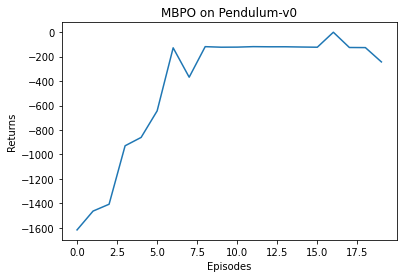

In [12]:
real_ratio = 0.5
env_name = 'Pendulum-v0'
env = gym.make(env_name)
num_episodes = 20
actor_lr = 5e-4
critic_lr = 5e-3
alpha_lr = 1e-3
hidden_dim = 128
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000  ## 缓冲池的容量
target_entropy = -1  ## 目标熵的大小
model_alpha = 0.01  # 模型损失函数中的加权权重
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值

## mbpo采样的状态个数
rollout_batch_size = 1000
## mbpo分支的步长
rollout_length = 1  # 推演长度k,推荐更多尝试
model_pool_size = rollout_batch_size * rollout_length

agent = SAC(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
            critic_lr, alpha_lr, target_entropy, tau, gamma)             ## 实例化智能体
model = EnsembleDynamicsModel(state_dim, action_dim, model_alpha)        ## 集成环境模型
fake_env = FakeEnv(model)                                                ## 虚拟环境的
env_pool = ReplayBuffer(buffer_size)                                     ## 真实交互数据缓冲池
model_pool = ReplayBuffer(model_pool_size)                               ## 和虚拟环境交互的数据的缓冲池
mbpo = MBPO(env, agent, fake_env, env_pool, model_pool, rollout_length,
            rollout_batch_size, real_ratio, num_episodes)                ## mbpo分支采样的

return_list = mbpo.train()  ## train

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('MBPO on {}'.format(env_name))
plt.show()

# episode: 1, return: -1083
# episode: 2, return: -1324
# episode: 3, return: -979
# episode: 4, return: -130
# episode: 5, return: -246
# episode: 6, return: -2
# episode: 7, return: -239
# episode: 8, return: -2
# episode: 9, return: -122
# episode: 10, return: -236
# episode: 11, return: -238
# episode: 12, return: -2
# episode: 13, return: -127
# episode: 14, return: -128
# episode: 15, return: -125
# episode: 16, return: -124
# episode: 17, return: -125
# episode: 18, return: -247
# episode: 19, return: -127
# episode: 20, return: -129